# Formula Electric at Berkeley
### Spring 2026 Simulations Recruitment Project by Bill Taing

Below, I import libraries, define vehicle/track parameters and constants, and read in the given motor torque curve data.

In [ ]:
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# vehicle parameters:
params = {'gg radius': 1,
          't1 radius': 50,
          'mass': 300,
          'tire friction coeff': 1,
          'tire radius': 0.254,
          'drive ratio': 4,
          'drag coeff': 0.8,
          'downforce coeff': 0,
          'frontal area': 1,
          'drivetrain eff': 0.9
          }

# track parameters:
track = {'straight': 500,
         'turn 1': 3.14 * params['t1 radius']
         }

# constants:
pi = 3.14
g = 9.81 # m/s^2 accel due to gravity
rho = 1.225 # kg/m^3, air density

mtc = pd.read_csv('motor_torque_curve.csv')
mtc.head()

,RPM,torque
0,0.669973,230.253555
1,50.662053,230.219731
2,157.921821,230.219731
3,265.181590,230.219731
4,372.441359,230.219731


This is a lap time simulation function I wrote in another file so that this notebook looks a little cleaner. The simulation uses calculations from the OpenLAP demo videos as well as the provided formulas in the project spec.

In [69]:
import sim_utils

def simulate(mesh_size):
    return sim_utils.simulate(mesh_size, params, track, mtc)

def lap_time(mesh_size):
    return simulate(mesh_size)['time delta'].sum()

Below is a sketch of the J track shape, with a straight for 500 meters and then a 180 degree turn with radius 50 m. The goal of this project is to find an accurate lap time for this track using a point mass model.

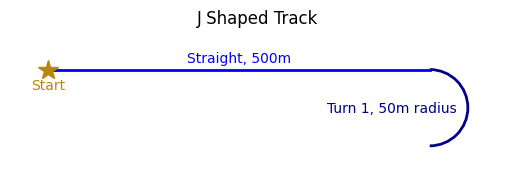

In [7]:
from matplotlib.patches import Arc
fig, ax = plt.subplots()

# Straight, 500m
ax.plot([0, 500], [100, 100], linewidth=2, color='blue')
# 180 deg turn on the right, 50m radius
arc = Arc((500, 50), width=100, height=100, theta1=270, theta2=90, linewidth=2, color='darkblue')
ax.add_patch(arc)

ax.set_aspect("equal")
ax.plot(0, 100, marker='*', color='darkgoldenrod', markersize=15, label='Start')
plt.xlim(-50,600)
plt.ylim(-50,150)
plt.text(0, 75, "Start", fontsize=10, ha='center', color='darkgoldenrod')
plt.text(250, 110, "Straight, 500m", fontsize=10, ha='center', color='blue')
plt.text(450, 50, "Turn 1, 50m radius", fontsize=10, ha='center', va='center', color='darkblue')
plt.title("J Shaped Track")
plt.axis('off')
plt.show()

Since mesh size is a parameter of my simulation function, I was curious if we can do some hyperparameter tuning to find the optimal mesh size for the lap time simulation. Below is a graph of various lap times for each mesh size from 1 to 50.

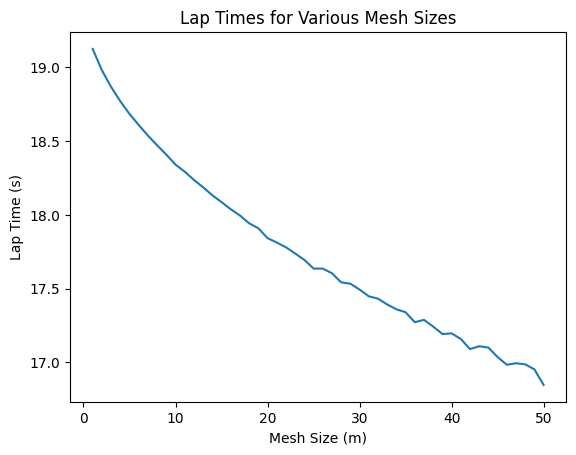

In [68]:
mesh_sizes = np.arange(1, 51)
trial_lap_times = pd.Series(mesh_sizes).apply(lap_time)
sns.lineplot(x=mesh_sizes, y=trial_lap_times)

plt.title("Lap Times for Various Mesh Sizes")
plt.xlabel("Mesh Size (m)")
plt.ylabel("Lap Time (s)")
plt.show()

Even though the lap times decrease as the mesh sizes get bigger, I realized that the smaller the mesh size is, the more realistic the lap time simulation is (because in real life change in speed is instantaneous), so I chose a mesh size of 1 meter.

In [71]:
simulation_1m = simulate(1)
print("Lap time for mesh size 1m:", lap_time(1), "seconds")
simulation_1m.head(10)

Lap time for mesh size 1m: 19.12407119460831 seconds


,section,dx,x,r,AT1 speed,DT1 speed,final speed,time delta,time since start,F_traction,RPM,engine torque,F_motor,F_drag,F_applied,F_actual
0,straight,0.0,0.0,0,0.000000,101.491379,0.000000,0.000000,0.000000,2943.0,0.000000,230.253555,3263.436207,0.0000,3263.436207,2943.0
1,straight,1.0,1.0,0,4.429447,101.491379,4.429447,0.225762,0.225762,2943.0,666.449709,230.219731,3262.956814,9.6138,3253.343014,2943.0
2,straight,1.0,2.0,0,6.264184,101.394674,6.264184,0.159638,0.385400,2943.0,942.502218,230.219731,3262.956814,19.2276,3243.729214,2943.0
3,straight,1.0,3.0,0,7.672027,101.297878,7.672027,0.130344,0.515743,2943.0,1154.324757,230.219731,3262.956814,28.8414,3234.115414,2943.0
4,straight,1.0,4.0,0,8.858894,101.200988,8.858894,0.112881,0.628624,2943.0,1332.899419,230.219731,3262.956814,38.4552,3224.501614,2943.0
5,straight,1.0,5.0,0,9.904544,101.104006,9.904544,0.100964,0.729588,2943.0,1490.226854,230.219731,3262.956814,48.0690,3214.887814,2943.0
6,straight,1.0,6.0,0,10.849885,101.006930,10.849885,0.092167,0.821755,2943.0,1632.461727,230.219731,3262.956814,57.6828,3205.274014,2943.0
7,straight,1.0,7.0,0,11.719215,100.909762,11.719215,0.085330,0.907085,2943.0,1763.260192,230.219731,3262.956814,67.2966,3195.660214,2943.0
8,straight,1.0,8.0,0,12.528368,100.812499,12.528368,0.079819,0.986904,2943.0,1885.004435,230.219731,3262.956814,76.9104,3186.046414,2943.0
9,straight,1.0,9.0,0,13.288341,100.715143,13.288341,0.075254,1.062157,2943.0,1999.349128,230.219731,3262.956814,86.5242,3176.432614,2943.0


Text(0, 0.5, 'Final speed (m/s)')

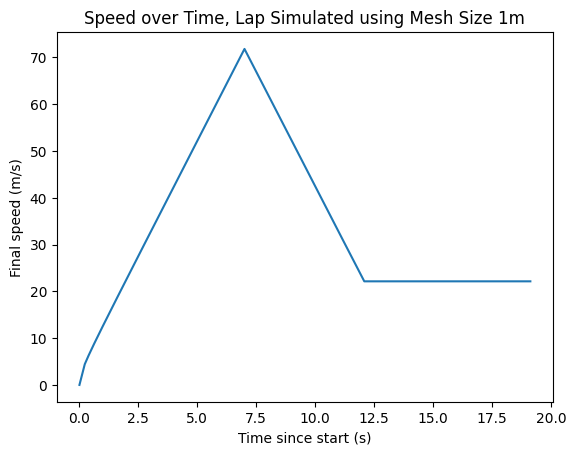

In [72]:
sns.lineplot(data=simulation_1m, x='time since start', y='final speed')
plt.title("Speed over Time, Lap Simulated using Mesh Size 1m")
plt.xlabel("Time since start (s)")
plt.ylabel("Final speed (m/s)")

Text(0, 0.5, 'Speed (m/s)')

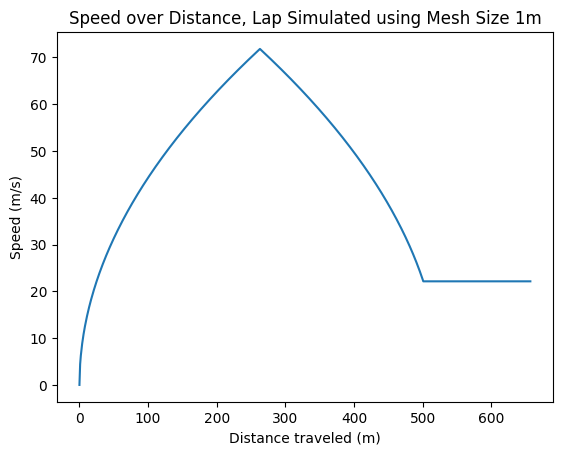

In [73]:
sns.lineplot(data=simulation_1m, x='x', y='final speed')
plt.title("Speed over Distance, Lap Simulated using Mesh Size 1m")
plt.xlabel("Distance traveled (m)")
plt.ylabel("Speed (m/s)")

In [74]:
max_speed = simulation_1m['final speed'].max()
print(f"The car starts decelerating/slowing down {500-simulation_1m[simulation_1m['final speed'] == max_speed]['x'].iloc[0]} meters before Turn 1 at a maximum speed of {max_speed} m/s.")

The car starts decelerating/slowing down 237.0 meters before Turn 1 at a maximum speed of 71.83355761759245 m/s.


Text(0.5, 1.0, 'Forces over Time, Lap Simulated using Mesh Size 1m')

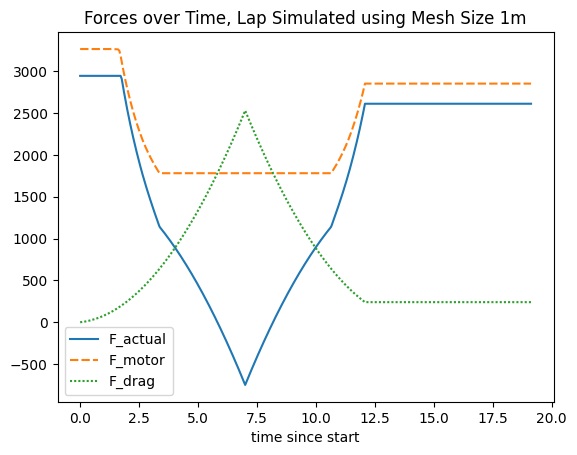

In [75]:
forces_1m = simulation_1m[['time since start', 'F_actual', 'F_motor', 'F_drag']].set_index('time since start')
sns.lineplot(data=forces_1m)
plt.title("Forces over Time, Lap Simulated using Mesh Size 1m")